In [2]:
import pandas
titanic = pandas.read_csv("train.csv")
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [89]:
# Basic data cleanup
def cleanup_data(data):
    # Add missing age -- set to median of existing ages.
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    # Convert features to numeric
    data.loc[data["Sex"] == "male", "Sex"] = 0
    data.loc[data["Sex"] == "female", "Sex"] = 1
    data["Embarked"] = data["Embarked"].fillna("S")
    data.loc[data["Embarked"] == "S", "Embarked"] = 0
    data.loc[data["Embarked"] == "C", "Embarked"] = 1
    data.loc[data["Embarked"] == "Q", "Embarked"] = 2
    # Add features
    data["FamilySize"] = data["SibSp"] + data["Parch"]
    data["NameLength"] = data["Name"].apply(lambda x: len(x))
    
    
cleanup_data(titanic)
titanic.describe()

TypeError: invalid type comparison

In [7]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic["Name"].apply(get_title)
pandas.value_counts(titles)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64

In [61]:
def get_titles_mapping(titles):
    mapping = {}
    idx = 0
    for title in titles.unique():
        mapping[title] = idx
        idx += 1
    return mapping

def add_titles_feature(data):
    titles = data["Name"].apply(get_title)
    mapping = get_titles_mapping(titles)
    for k, v in mapping.items():
        titles[titles == k] = v
    data["Title"] = titles

    
add_titles_feature(titanic)
print(titanic["Title"].describe())    
    
# Add family ids    
import operator

def add_family_id(data):
    family_id_mapping = {}
    # A function to get the id given a row
    def get_family_id(row):
        # Find the last name by splitting on a comma
        last_name = row["Name"].split(",")[0]
        # Create the family id
        family_id = "{0}{1}".format(last_name, row["FamilySize"])
        # Look up the id in the mapping
        if family_id not in family_id_mapping:
            if len(family_id_mapping) == 0:
                current_id = 1
            else:
                # Get the maximum id from the mapping and add one to it if we don't have an id
                current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
            family_id_mapping[family_id] = current_id
        return family_id_mapping[family_id]
    family_ids = data.apply(get_family_id, axis=1)
    family_ids[data["FamilySize"] < 3] = -1
    data["FamilyId"] = family_ids

add_family_id(titanic)

count     891
unique     17
top         0
freq      517
Name: Title, dtype: int64
count    891.000000
mean      14.232323
std       69.886368
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max      633.000000
Name: FamilyId, dtype: float64


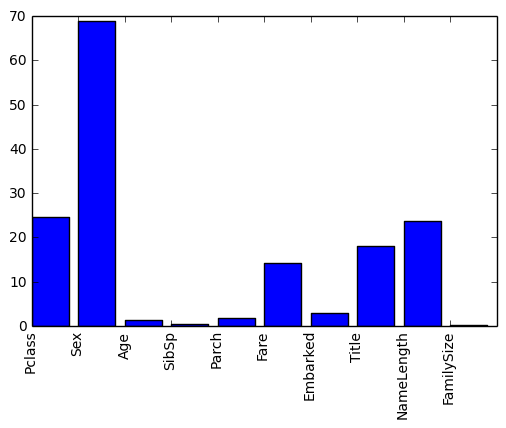

In [27]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "NameLength", "FamilySize"]
# TODO: what other options are available for prediction selection?
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])
scores = -np.log10(selector.pvalues_)

% matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [81]:
from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

algos = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3),
     ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1),
     ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

def get_predictions(data, algos):
    kf = cross_validation.KFold(data.shape[0], n_folds=3, random_state=1)
    predictions = []
    for train, test in kf:
        train_target = data["Survived"].iloc[train]
        full_test_predictions = []
        # Make predictions for each algorithm on each fold
        for alg, predictors in algos:
            # Fit the algorithm on the training data.
            alg.fit(data[predictors].iloc[train,:], train_target)
            # Select and predict on the test fold.  
            # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
            test_predictions = alg.predict_proba(data[predictors].iloc[test,:].astype(float))[:,1]
            full_test_predictions.append(test_predictions)
        # An ensembling scheme that gives the gradient more weight.
        test_predictions = (full_test_predictions[0] * 5 + full_test_predictions[1]) / 6
        # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
        test_predictions[test_predictions <= .5] = 0
        test_predictions[test_predictions > .5] = 1
        predictions.append(test_predictions)
    # Put all the predictions together into one array.
    predictions = np.concatenate(predictions, axis=0)
    return pandas.Series(predictions)

def get_accuracy(predictions, data):
    return sum(predictions == data["Survived"]) * 1.0 / len(predictions)

predictions = get_predictions(titanic, algos)
accuracy = get_accuracy(predictions, titanic)
print(accuracy)


0.82379349046


In [91]:
# Submission.
titanic_test = pandas.read_csv("titanic_test.csv")

cleanup_data(titanic_test)
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

add_titles_feature(titanic_test)
add_family_id(titanic_test)

full_predictions = []
for alg, predictors in algos:
    alg.fit(titanic[predictors], titanic["Survived"])
    floats = titanic_test[predictors].astype(float)
    print(floats)
    predictions = alg.predict_proba(floats)[:,1]
    full_predictions.append(predictions)
predictions = (full_predictions[0] * 5 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pandas.DataFrame({
    "PassengerId": titanic_test["PassengerId"],
    "Survived": predictions
})
submission.to_csv("kaggle.csv", index=False)

     Pclass  Sex   Age      Fare  Embarked  FamilySize  Title  FamilyId
0       3.0  0.0  34.5    7.8292       2.0         0.0    0.0      -1.0
1       3.0  1.0  47.0    7.0000       0.0         1.0    1.0      -1.0
2       2.0  0.0  62.0    9.6875       2.0         0.0    0.0      -1.0
3       3.0  0.0  27.0    8.6625       0.0         0.0    0.0      -1.0
4       3.0  1.0  22.0   12.2875       0.0         2.0    1.0      -1.0
5       3.0  0.0  14.0    9.2250       0.0         0.0    0.0      -1.0
6       3.0  1.0  30.0    7.6292       2.0         0.0    2.0      -1.0
7       2.0  0.0  26.0   29.0000       0.0         2.0    0.0      -1.0
8       3.0  1.0  18.0    7.2292       1.0         0.0    1.0      -1.0
9       3.0  0.0  21.0   24.1500       0.0         2.0    0.0      -1.0
10      3.0  0.0  27.0    7.8958       0.0         0.0    0.0      -1.0
11      1.0  0.0  46.0   26.0000       0.0         0.0    0.0      -1.0
12      1.0  1.0  23.0   82.2667       0.0         1.0    1.0   